In [9]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import glob

import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from random import randint
from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

import segmentation_models as sm

from concurrent.futures import ThreadPoolExecutor, as_completed

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [11]:
# helper function for data visualization
def visualize(**images):
	"""PLot images in one row."""
	n = len(images)
	plt.figure(figsize=(16, 5))
	for i, (name, image) in enumerate(images.items()):
		plt.subplot(1, n, i + 1)
		plt.xticks([])
		plt.yticks([])
		plt.title(' '.join(name.split('_')).title())
		plt.imshow(image)
	plt.show()

# Import dataset

In [12]:
"""
	undefined (0)
	lepidic (1)
	acinar (2)
	micropapillary (3)
	papillary (4)
	solid (5)
"""

'\n\tundefined (0)\n\tlepidic (1)\n\tacinar (2)\n\tmicropapillary (3)\n\tpapillary (4)\n\tsolid (5)\n'

In [13]:
class Dataset():
	def __init__(
			self, 
			root,
			augmentation=None, 
			preprocessing=None,
		):
		self.classes = ['background', 'lepidic', 'acinar', 'micropapillary', 'papillary', 'solid']


		self.images_path = glob.glob(str(root / "images/*"))
		self.masks_path = glob.glob(str(root / "masks/*"))

		print(self.images_path)
		print(self.masks_path)
  
		# collecting sample for every class
		to_collect = [0, 10, 10, 10, 10, 10]
		self.images_test_path = []
		self.masks_test_path = []

		def collect_sample(img_p, msk_p):
			mask = np.asarray(imread(msk_p), dtype=np.uint8)

			c = np.unique(self.to_index(mask))[-1]

			if to_collect[c] == 0: return 

			to_collect[c] -= 1

			self.images_test_path.append(img_p)
			self.masks_test_path.append(msk_p)

			self.images_path.remove(img_p)
			self.masks_path.remove(msk_p)

		# multithread
		futures = []
		with ThreadPoolExecutor(max_workers=8) as executor:
			for img_p, msk_p in zip(self.images_path, self.masks_path):
				futures.append(executor.submit(collect_sample, img_p, msk_p))
		
			# Wait for all futures to complete
			for future in as_completed(futures):
				future.result()  # This will raise any exceptions that occurred

		
		print("Collect state: ", to_collect)

		self.augmentation = augmentation
		self.preprocessing = preprocessing


	def merge(self, x):
		dim = (x.shape[-2], x.shape[-1])
		merged = np.zeros(dim)
		for i in range(len(self.classes)):
			merged = np.where(merged==0, x[i], merged)

		merged  = merged.reshape(dim[0], dim[1], 1)

		return merged


	def to_index(self, x):
		for c in range(len(self.classes)):
			x[c][x[c] == 255] = c 
		
		return x


	def export_split(self, a, b, ratio = 0.5, cat = False):
		
		l_size = int(len(a) * ratio)

		images = np.asarray([imread(x) for x in a], dtype=np.uint8)
		masks = np.asarray([self.merge(self.to_index(imread(x))) for x in b], dtype=np.uint8)

		print("Input images and masks shape: ", images.shape, masks.shape)
		
		if cat:
			masks = to_categorical(masks, num_classes=len(self.classes))

		x_left = images[:l_size]
		y_left = masks[:l_size]

		x_right = images[l_size:]
		y_right = masks[l_size:]

		return x_left, y_left, x_right, y_right


	def __getitem__(self, i):
		
		# read data
		image = np.asarray(imread(self.images_path[i]), dtype=np.uint8)
		mask = np.asarray(imread(self.masks_path[i]), dtype=np.uint8)

		mask = self.to_index(mask)
		mask = self.merge(mask)

		# apply augmentations
		if self.augmentation:
			sample = self.augmentation(image=image, mask=mask)
			image, mask = sample['image'], sample['mask']
		
		# apply preprocessing
		if self.preprocessing:
			sample = self.preprocessing(image=image, mask=mask)
			image, mask = sample['image'], sample['mask']
			
		return image, mask
		
	def __len__(self):
		return len(self.images_path)

In [14]:
# 512px*512px of 1x downsampled images
SIZE = 512
root = Path(r'D:\NSC2024\annotated\merged\1')

dataset = Dataset(root=root)

['D:\\NSC2024\\annotated\\merged\\1\\images\\S56-01604 phD B [x=77056,y=48832,w=512,h=512].tif', 'D:\\NSC2024\\annotated\\merged\\1\\images\\S56-01604 phD B [x=77056,y=49280,w=512,h=512].tif', 'D:\\NSC2024\\annotated\\merged\\1\\images\\S56-01604 phD B [x=77056,y=49728,w=512,h=512].tif', 'D:\\NSC2024\\annotated\\merged\\1\\images\\S56-01604 phD B [x=77056,y=50176,w=512,h=512].tif', 'D:\\NSC2024\\annotated\\merged\\1\\images\\S56-01604 phD B [x=77504,y=48832,w=512,h=512].tif', 'D:\\NSC2024\\annotated\\merged\\1\\images\\S56-01604 phD B [x=77504,y=49280,w=512,h=512].tif', 'D:\\NSC2024\\annotated\\merged\\1\\images\\S56-01604 phD B [x=77504,y=49728,w=512,h=512].tif', 'D:\\NSC2024\\annotated\\merged\\1\\images\\S56-01604 phD B [x=77504,y=50176,w=512,h=512].tif', 'D:\\NSC2024\\annotated\\merged\\1\\images\\S56-01604 phD B [x=77504,y=51520,w=512,h=512].tif', 'D:\\NSC2024\\annotated\\merged\\1\\images\\S56-01604 phD B [x=77504,y=51968,w=512,h=512].tif', 'D:\\NSC2024\\annotated\\merged\\1\\ima

Length of dataset:  1323
Mask unique:  [0. 5.]
Mask shape:  (512, 512, 1)


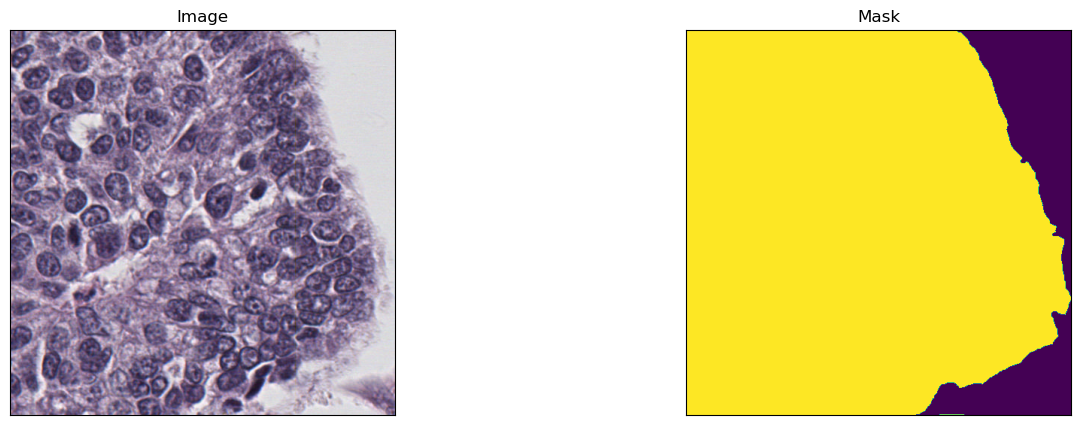

In [8]:
print("Length of dataset: ", len(dataset))
r = randint(0, len(dataset) - 1)
image, masks = dataset[r]

print("Mask unique: ", np.unique(masks))
print("Mask shape: ", masks.shape)
visualize(
	image=image,
	mask=masks
)

# Define the model

In [17]:
class model():
	def __init__(self, arch, backbone, encoder, lr, activation):
		self.arch = arch
		self.backbone = backbone

		# callbacks
		self.checkpoint = tf.keras.callbacks.ModelCheckpoint(
			f'./models/{arch}/{backbone}/best_model.keras',
			monitor='iou_score',
			verbose=1,
			save_best_only=True,
			save_weights_only=False,
			mode='max',
			save_freq='epoch',
			initial_value_threshold=None
		)
		name = arch + "-" + backbone
		self.tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"logs/{name}")
		
		# loss functions
		class_indexes = [1, 2, 3, 4, 5]
		dice_loss = sm.losses.DiceLoss(class_weights=np.array([0, .2, .2, .2, .2, .2]), per_image=True) 
		focal_loss = sm.losses.CategoricalFocalLoss(class_indexes=class_indexes)
		jaccard_loss = sm.losses.JaccardLoss(class_indexes=class_indexes, per_image=True)
		total_loss = dice_loss + (1 * focal_loss) + jaccard_loss 

		# metrices
		metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
		self.preprocess = sm.get_preprocessing(backbone)

		opt = keras.optimizers.Adam(lr)

		if arch == "Unet":
			self.model = sm.Unet(backbone_name=backbone, encoder_weights=encoder, activation=activation, classes=6, input_shape=(SIZE, SIZE, 3))
			self.model.compile(opt, loss=total_loss, metrics=metrics)
		else:
			print("Unknown model arch. The model is undefined.")
	

	def summary(self):
		self.model.summary()


	def train(self):
		SET_SIZE = 256
		cnt = 1

		batch_size = 8

		epoch_size = 20
		initial_epoch = 0

		goal = len(dataset)
		for i in tqdm(range(0, goal, SET_SIZE)):
			x_train, y_train, x_val, y_val = dataset.export_split(dataset.images_path[i:i+SET_SIZE], dataset.masks_path[i:i+SET_SIZE], ratio=0.8, cat=True)

			pre_x_train = self.preprocess(x_train)
			pre_x_val = self.preprocess(x_val)

			history = self.model.fit(pre_x_train, y_train,
									validation_data=(pre_x_val, y_val),
									batch_size=batch_size,
									shuffle=True,
									verbose=1,
									initial_epoch=initial_epoch,
									epochs=initial_epoch + epoch_size,
									callbacks=[self.checkpoint, self.tensorboard]
								)

			self.model.save(f'./models/{self.arch}/{self.backbone}/latest_after_{initial_epoch + epoch_size}_epochs.keras')

			cnt += 1
			initial_epoch += epoch_size
	

In [18]:
model = model(arch="Unet", backbone="resnet34", encoder="imagenet", activation="softmax", lr=0.0001)

In [31]:
model.train()

  0%|          | 0/6 [00:00<?, ?it/s]

(256, 512, 512, 3) (256, 512, 512, 1)
Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - f1-score: 0.0166 - iou_score: 0.0107 - loss: 1.9900
Epoch 1: iou_score improved from -inf to 0.03897, saving model to ./models/Unet/resnet34/best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 271s 9s/step - f1-score: 0.0178 - iou_score: 0.0117 - loss: 1.9898 - val_f1-score: 0.3333 - val_iou_score: 0.3333 - val_loss: 2.0080
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - f1-score: 0.1114 - iou_score: 0.0888 - loss: 1.9675
Epoch 2: iou_score improved from 0.03897 to 0.16513, saving model to ./models/Unet/resnet34/best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 226s 9s/step - f1-score: 0.1146 - iou_score: 0.0916 - loss: 1.9672 - val_f1-score: 0.3352 - val_iou_score: 0.3343 - val_loss: 2.0013
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - f1-score: 0.3781 - iou_score: 0.3253 - loss: 1.9297
Epoch 3: iou_score improved from 0.16513 to 0.32456, saving model to ./models/Unet/resnet34/best_model.keras
26/26 ━━━

 17%|█▋        | 1/6 [1:17:06<6:25:34, 4626.89s/it]

(256, 512, 512, 3) (256, 512, 512, 1)
Epoch 21/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - f1-score: 0.2421 - iou_score: 0.2199 - loss: 2.0082
Epoch 21: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 234s 8s/step - f1-score: 0.2430 - iou_score: 0.2207 - loss: 2.0066 - val_f1-score: 0.2748 - val_iou_score: 0.2486 - val_loss: 1.9094
Epoch 22/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - f1-score: 0.2926 - iou_score: 0.2691 - loss: 1.8997
Epoch 22: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 216s 8s/step - f1-score: 0.2927 - iou_score: 0.2692 - loss: 1.8993 - val_f1-score: 0.2857 - val_iou_score: 0.2610 - val_loss: 1.8875
Epoch 23/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - f1-score: 0.3017 - iou_score: 0.2824 - loss: 1.8683
Epoch 23: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 215s 8s/step - f1-score: 0.3016 - iou_score: 0.2823 - loss: 1.8684 - val_f1-score: 0.2848 - val_iou_score: 0.2600 - val_loss: 1.8885
Epoch 24/40
26/26 ━━━━━

 33%|███▎      | 2/6 [2:27:40<4:53:02, 4395.64s/it]

(256, 512, 512, 3) (256, 512, 512, 1)
Epoch 41/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - f1-score: 0.2944 - iou_score: 0.2716 - loss: 1.8900
Epoch 41: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 214s 8s/step - f1-score: 0.2946 - iou_score: 0.2719 - loss: 1.8894 - val_f1-score: 0.2713 - val_iou_score: 0.2489 - val_loss: 1.9546
Epoch 42/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - f1-score: 0.3033 - iou_score: 0.2837 - loss: 1.8551
Epoch 42: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - f1-score: 0.3033 - iou_score: 0.2837 - loss: 1.8551 - val_f1-score: 0.2870 - val_iou_score: 0.2689 - val_loss: 1.8778
Epoch 43/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - f1-score: 0.3044 - iou_score: 0.2852 - loss: 1.8483
Epoch 43: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 204s 8s/step - f1-score: 0.3045 - iou_score: 0.2853 - loss: 1.8483 - val_f1-score: 0.2863 - val_iou_score: 0.2687 - val_loss: 1.8676
Epoch 44/60
26/26 ━━━━━

 50%|█████     | 3/6 [3:36:25<3:33:36, 4272.02s/it]

(256, 512, 512, 3) (256, 512, 512, 1)
Epoch 61/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - f1-score: 0.3085 - iou_score: 0.2920 - loss: 1.8495
Epoch 61: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 215s 8s/step - f1-score: 0.3084 - iou_score: 0.2919 - loss: 1.8496 - val_f1-score: 0.3124 - val_iou_score: 0.2979 - val_loss: 1.8439
Epoch 62/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - f1-score: 0.3089 - iou_score: 0.2928 - loss: 1.8424
Epoch 62: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 213s 8s/step - f1-score: 0.3090 - iou_score: 0.2929 - loss: 1.8422 - val_f1-score: 0.3127 - val_iou_score: 0.2983 - val_loss: 1.8379
Epoch 63/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - f1-score: 0.3109 - iou_score: 0.2951 - loss: 1.8407
Epoch 63: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - f1-score: 0.3111 - iou_score: 0.2953 - loss: 1.8403 - val_f1-score: 0.3130 - val_iou_score: 0.2986 - val_loss: 1.8391
Epoch 64/80
26/26 ━━━━━

 67%|██████▋   | 4/6 [4:45:56<2:21:04, 4232.31s/it]

(256, 512, 512, 3) (256, 512, 512, 1)
Epoch 81/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - f1-score: 0.0256 - iou_score: 0.0143 - loss: 2.0087
Epoch 81: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 209s 8s/step - f1-score: 0.0253 - iou_score: 0.0142 - loss: 2.0085 - val_f1-score: 0.0477 - val_iou_score: 0.0477 - val_loss: 2.0291
Epoch 82/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - f1-score: 0.0255 - iou_score: 0.0141 - loss: 1.9758
Epoch 82: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - f1-score: 0.0259 - iou_score: 0.0145 - loss: 1.9759 - val_f1-score: 0.0714 - val_iou_score: 0.0714 - val_loss: 2.0158
Epoch 83/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - f1-score: 0.0566 - iou_score: 0.0332 - loss: 1.9705
Epoch 83: iou_score did not improve from 0.34882
26/26 ━━━━━━━━━━━━━━━━━━━━ 208s 8s/step - f1-score: 0.0573 - iou_score: 0.0337 - loss: 1.9702 - val_f1-score: 0.0766 - val_iou_score: 0.0644 - val_loss: 1.9836
Epoch 84/100
26/26 ━

 83%|████████▎ | 5/6 [5:55:04<1:10:01, 4201.72s/it]

(43, 512, 512, 3) (43, 512, 512, 1)
Epoch 101/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - f1-score: 8.7108e-04 - iou_score: 4.4092e-04 - loss: 2.0876
Epoch 101: iou_score did not improve from 0.34882
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - f1-score: 9.0152e-04 - iou_score: 4.5639e-04 - loss: 2.0881 - val_f1-score: 0.0834 - val_iou_score: 0.0833 - val_loss: 2.0416
Epoch 102/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - f1-score: 4.2937e-04 - iou_score: 2.1506e-04 - loss: 2.0733
Epoch 102: iou_score did not improve from 0.34882
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - f1-score: 4.1082e-04 - iou_score: 2.0576e-04 - loss: 2.0732 - val_f1-score: 0.0833 - val_iou_score: 0.0833 - val_loss: 2.0329
Epoch 103/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - f1-score: 3.7019e-04 - iou_score: 1.8591e-04 - loss: 2.0489
Epoch 103: iou_score did not improve from 0.34882
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - f1-score: 3.9920e-04 - iou_score: 2.0056e-04 - loss: 2.0469 - val_f1-score: 0.0833 - val_iou_score: 0.0833 - 

100%|██████████| 6/6 [6:06:40<00:00, 3666.73s/it]  


In [15]:
from keras.models import load_model
loaded_model = load_model('./models/Unet/resnet34/latest_after_120_epochs.keras', compile=False)

In [19]:
x_test, y_test, x_empty, y_empty = dataset.export_split(dataset.images_test_path, dataset.masks_test_path, 1, cat=False)
x_test = model.preprocess(x_test)
y_pred = loaded_model.predict(x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
print(y_pred_argmax.shape, np.unique(y_pred_argmax))

Input images and masks shape:  (50, 512, 512, 3) (50, 512, 512, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step
(50, 512, 512) [1 2 3 4 5]


In [20]:
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=len(dataset.classes)+1)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
		

Mean IoU = 0.07105113


In [21]:
def gray_to_rgb(x):
    x_reshaped = np.concatenate([x] * 3, axis=-1)
    color_map = {
            1: [255, 0, 0],   # Red for lepidic
            2: [0, 255, 0],   # Green for acinar
            3: [0, 0, 255],    # Blue for micropapillary
            4: [255, 255, 0],  # Yellow for papillary
            5: [255, 0, 255],   # violet for solid
        }
    
    rgb = np.zeros_like(x_reshaped, dtype=np.uint8)
    for label, color in color_map.items():
            rgb[x_reshaped[..., 0] == label] = color 
    return rgb

In [22]:
# Convert to colors according to classes
y_test_rgb = gray_to_rgb(y_test)
y_pred_argmax_expanded = np.expand_dims(y_pred_argmax, axis=-1)
y_pred_argmax_rgb = gray_to_rgb(y_pred_argmax_expanded)

y_test shape:  (50, 512, 512, 1)
y_test unique:  [0 2]
y_pred_argmax_rgb shape:  (50, 512, 512, 3)
y_pred_argmax shape:  (50, 512, 512)
y_pred_argmax unique:  [1 2 3 4 5]


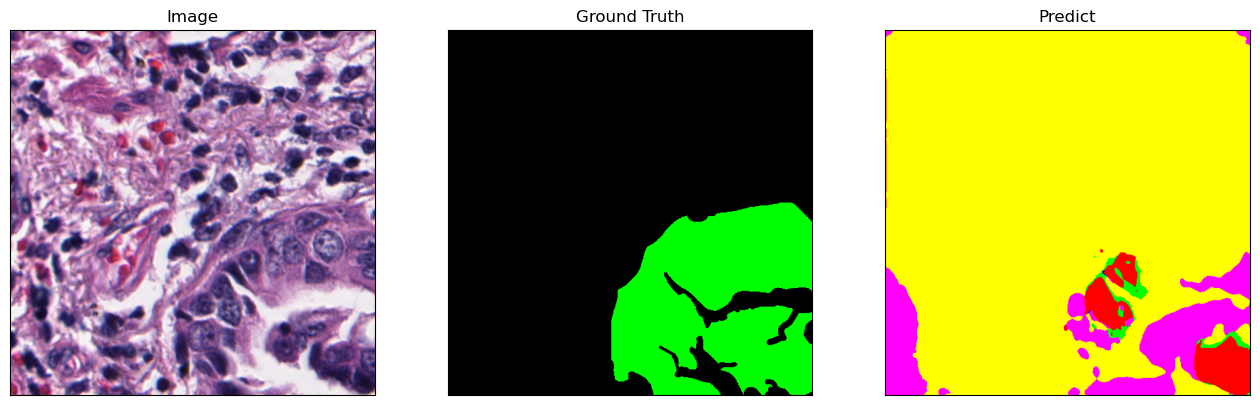

In [75]:

idx = randint(0, len(x_test)-1)
# idx = 16
print("y_test shape: ", y_test.shape)
print("y_test unique: ", np.unique(y_test[idx]))
print("y_pred_argmax_rgb shape: ", y_pred_argmax_rgb.shape)
print("y_pred_argmax shape: ", y_pred_argmax.shape)
print("y_pred_argmax unique: ", np.unique(y_pred_argmax[idx]))

visualize(
	image=x_test[idx],
	ground_truth=y_test_rgb[idx],
	predict=y_pred_argmax_rgb[idx],
)

# array = np.full((50, 512, 512, 1), 2)
# array_rgb = gray_to_rgb(array)

# st = np.concatenate([array]*3,axis=-1)
# print(st.shape)
# # print(st)

# Red for lepidic
# Green for acinar
# Blue for micropapillary
# Yellow for papillary
# violet for solid